In [1]:
!pip install torchvision

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np

from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines
import cv2
import tifffile
from PIL import Image
import time, os

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
#import torchvision.transforms as transforms

from tensorflow.keras.models import load_model
from tensorflow.image import resize_with_pad
from tensorflow import expand_dims
from tensorflow.nn import softmax


In [3]:
def imread(image_up):
    ext = os.path.splitext(image_up.name)[-1]
    if ext== '.tif' or ext=='tiff':
        img = tifffile.imread(image_up)
        return img
    else:
        img = plt.imread(image_up)
    return img

def run_segmentation(model, image, diam, channels, flow_threshold, cellprob_threshold):
    masks, flows, styles, diams = model.eval(image, 
            # batch_size = 8,
            diameter = diam, # 100
            channels = channels,
            invert = True,
            # rescale = 0.5,
            net_avg=False,
            flow_threshold = flow_threshold, # 1
            cellprob_threshold = cellprob_threshold, # -4
                            )
    return masks, flows, styles, diams

#from cellpose
# @st.cache
def show_cell_outlines(img, maski, color_mask):

    outlines = masks_to_outlines(maski)
    
    # plot the WordCloud image     
    fig, ax = plt.subplots(figsize = (8, 8))                   
    outX, outY = np.nonzero(outlines)
    imgout= img.copy()
    h = color_mask.lstrip('#')
    hex2rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    imgout[outX, outY] = hex2rgb
    # imgout[outX, outY] = np.array([255,75,75])
    ax.imshow(imgout)
    #for o in outpix:
    #    ax.plot(o[:,0], o[:,1], color=[1,0,0], lw=1)
    ax.set_title('Predicted outlines')
    ax.axis('off')
    
    return fig

def get_cell_outlines(masks):
    outlines_ls = outlines_list(masks)
    return outlines_ls

def transform_image(arr):
    my_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        # transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
#     image = Image.open(io.BytesIO(image_bytes))
    im = Image.fromarray(arr)
    return my_transforms(im).unsqueeze(0)

class_names = ['parasitized', 'uninfected']

def get_prediction(arr):
    tensor = transform_image(arr)
    outputs = model.forward(tensor)
    _, y_hat = outputs.max(1)
    return class_names[y_hat]

def get_prediction_tf(arr):
    arr = resize_with_pad(arr, 100, 100, method= 'bilinear', antialias=False)
    arr = expand_dims(arr, 0) # Create a batch
    predictions = pair_D_ensemble_model.predict(arr)
    score = softmax(predictions[0])
    #print(class_names[np.argmax(score)])
    return class_names[np.argmax(score)]

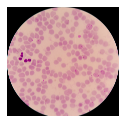

In [4]:
org_files = ['../data/fit_to_circle/test/cropped_P3_IMG_20150621_112138.png',
            '../data/fit_to_circle/train/cropped_P206_IMG_20151112_164625.png', 
            '../data/fit_to_circle/test/cropped_P201_IMG_20151029_162934.png',
            '../data/fit_to_circle/train/cropped_P50_IMG_20150820_162504.png'
            ]
org_files = ['../data/fit_to_circle/cropped_P3_IMG_20150621_112138.png',
            '../data/fit_to_circle/cropped_P206_IMG_20151112_164625.png', 
            '../data/fit_to_circle/cropped_P201_IMG_20151029_162934.png',
            '../data/fit_to_circle/cropped_P50_IMG_20150820_162504.png'
            ]

# view 1 image
img = io.imread(org_files[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
imgs = [cv2.imread(img_path) for img_path in org_files]

img_height = 1024
img_width = 1024
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [6]:
diameter = 140

** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.82s; flow+mask computation 2.38
estimated masks for 1 image(s) in 3.59 sec
>>>> TOTAL TIME 3.59 sec


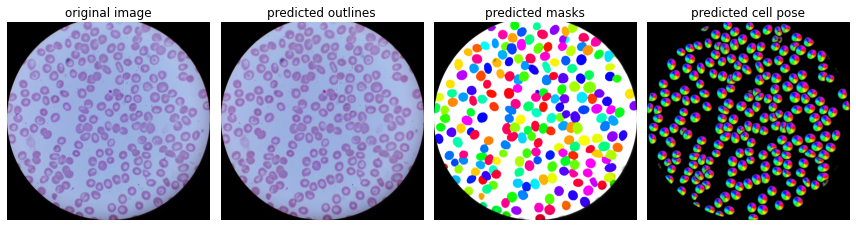

processing 1 image(s)
time spent: running network 0.71s; flow+mask computation 1.83
estimated masks for 1 image(s) in 2.97 sec
>>>> TOTAL TIME 2.97 sec


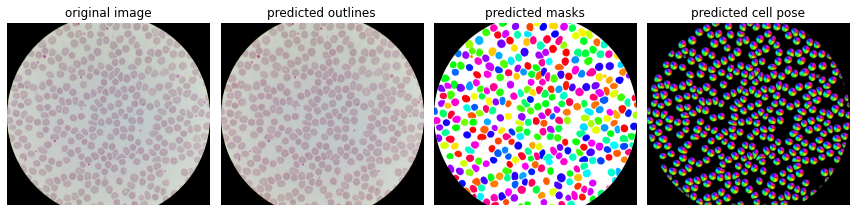

processing 1 image(s)
time spent: running network 0.76s; flow+mask computation 1.85
estimated masks for 1 image(s) in 3.03 sec
>>>> TOTAL TIME 3.03 sec


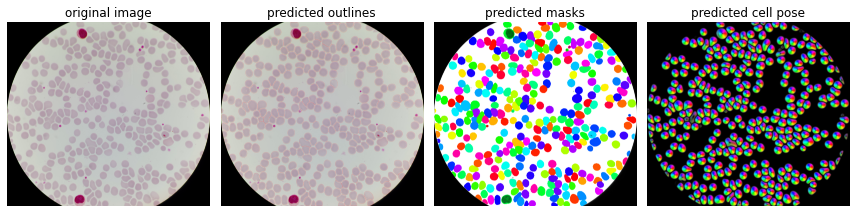

processing 1 image(s)
time spent: running network 0.70s; flow+mask computation 1.71
estimated masks for 1 image(s) in 2.78 sec
>>>> TOTAL TIME 2.79 sec


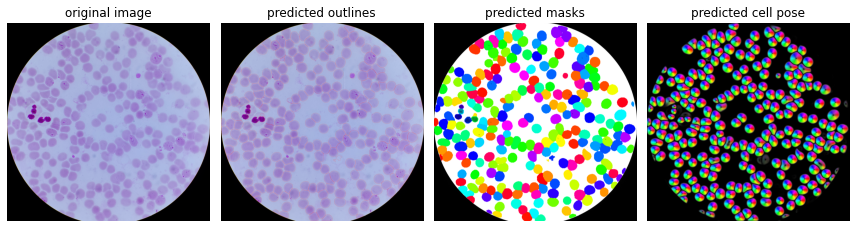

In [7]:
model = models.Cellpose(gpu=True, model_type='cyto')

masks_all = []

for img in imgs:
    chan = [0, 0] # for black and white imgs

    masks, flows, styles, diams = model.eval(img, 
                                 diameter= diameter, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1,
                                 #cellprob_threshold = -2,
                                                )

    masks_all.append(masks)
    
    # DISPLAY RESULTS

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()

In [8]:
pair_D_ensemble_model=load_model('../data/weights/ensemblemodel_pairD.h5')
pair_D_ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
___________________________________________________________________________________________

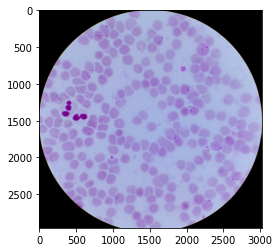

In [9]:
plt.imshow(img)

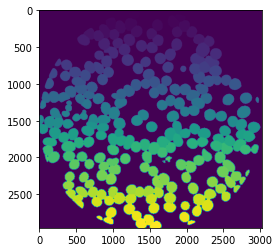

In [10]:
plt.imshow(masks)

In [11]:
image = img
size_thres = diameter*0.5
tmp_img = image.copy()
d_results = {"parasitized": [],
            "uninfected": [],
            }

since = time.time()
for idx, cell in enumerate(outlines_ls[:]):

    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    if (y.max() - y.min()) < size_thres or (x.max() - x.min()) < size_thres:
        continue

    # mask outline
    mask = np.zeros(tmp_img.shape, dtype=np.uint8)
    channel_count = tmp_img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    # fill contour
    cv2.fillConvexPoly(mask, cell, ignore_mask_color)
    # extract roi
    masked_image = cv2.bitwise_and(tmp_img, mask)
    # crop the box around the cell
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = masked_image[topy:bottomy+1, topx:bottomx+1,:]
    
    # predict the stage of the cell p
    stage = get_prediction_tf(out)
    d_results[stage].append(idx)
    
time_elapsed = time.time() - since
print(time_elapsed)




colors_stage = { "uninfected": [1, 0, 0], "parasitized": "#FF0000"}
fig, ax = plt.subplots(figsize = (8,8))
# yellow: ring; magenta: troph; cyan: shiz
ax.imshow(image)


for k in class_names:
    if k!= "uninfected" and len(d_results[k]) > 0:
        for cell in d_results[k]:
            coord = outlines_ls[cell]
            ax.plot(coord[:,0], coord[:,1], c = colors_stage[k], lw=1)
ax.set_title('Predicted infected cells')
ax.axis('off')
#plt.imshow(fig)

total_count = sum(len(v)for v in d_results.values())
out_stat = []
for key in class_names:
    stage_count = len(d_results[key])
    # st.write(key, stage_count, round(stage_count/total_count, 3))
    paras = round(stage_count/total_count, 3)
    out_stat.append((stage_count, paras))
par = (1 - out_stat[0][1])*100
print(f"""
    | Stage      |      Count         |       %             |
    | -----------| -------------      | ----------          |
    | Parasitized| {out_stat[0][0]}   |  {out_stat[0][1]}   | 
    | Uninfected | {out_stat[1][0]}   |  {out_stat[1][1]}   |

""")

NameError: name 'outlines_ls' is not defined

In [ ]:
fig.savefig('../data/fit_to_circle/results/first_test.png', dpi = 1000)